<a href="https://colab.research.google.com/github/Arsh-e-Barin-Khurshid/CodexCue-Software-Solutions-Task-4-Car-Price-Prediction-ML/blob/main/Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Load the dataset
data = pd.read_csv('/content/cardekho.csv')

In [3]:
# Data Exploration
print("Dataset Info:")
print(data.info())  # Overview of the dataset

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                8128 non-null   object 
 1   year                8128 non-null   int64  
 2   selling_price       8128 non-null   int64  
 3   km_driven           8128 non-null   int64  
 4   fuel                8128 non-null   object 
 5   seller_type         8128 non-null   object 
 6   transmission        8128 non-null   object 
 7   owner               8128 non-null   object 
 8   mileage(km/ltr/kg)  7907 non-null   float64
 9   engine              7907 non-null   float64
 10  max_power           7913 non-null   object 
 11  seats               7907 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 762.1+ KB
None


In [4]:
print("\nSummary Statistics:")
print(data.describe())  # Summary statistics


Summary Statistics:
              year  selling_price     km_driven  mileage(km/ltr/kg)  \
count  8128.000000   8.128000e+03  8.128000e+03         7907.000000   
mean   2013.804011   6.382718e+05  6.981951e+04           19.418783   
std       4.044249   8.062534e+05  5.655055e+04            4.037145   
min    1983.000000   2.999900e+04  1.000000e+00            0.000000   
25%    2011.000000   2.549990e+05  3.500000e+04           16.780000   
50%    2015.000000   4.500000e+05  6.000000e+04           19.300000   
75%    2017.000000   6.750000e+05  9.800000e+04           22.320000   
max    2020.000000   1.000000e+07  2.360457e+06           42.000000   

            engine        seats  
count  7907.000000  7907.000000  
mean   1458.625016     5.416719  
std     503.916303     0.959588  
min     624.000000     2.000000  
25%    1197.000000     5.000000  
50%    1248.000000     5.000000  
75%    1582.000000     5.000000  
max    3604.000000    14.000000  


In [5]:
print("\nMissing Values Count:")
print(data.isnull().sum())  # Check for missing values


Missing Values Count:
name                    0
year                    0
selling_price           0
km_driven               0
fuel                    0
seller_type             0
transmission            0
owner                   0
mileage(km/ltr/kg)    221
engine                221
max_power             215
seats                 221
dtype: int64


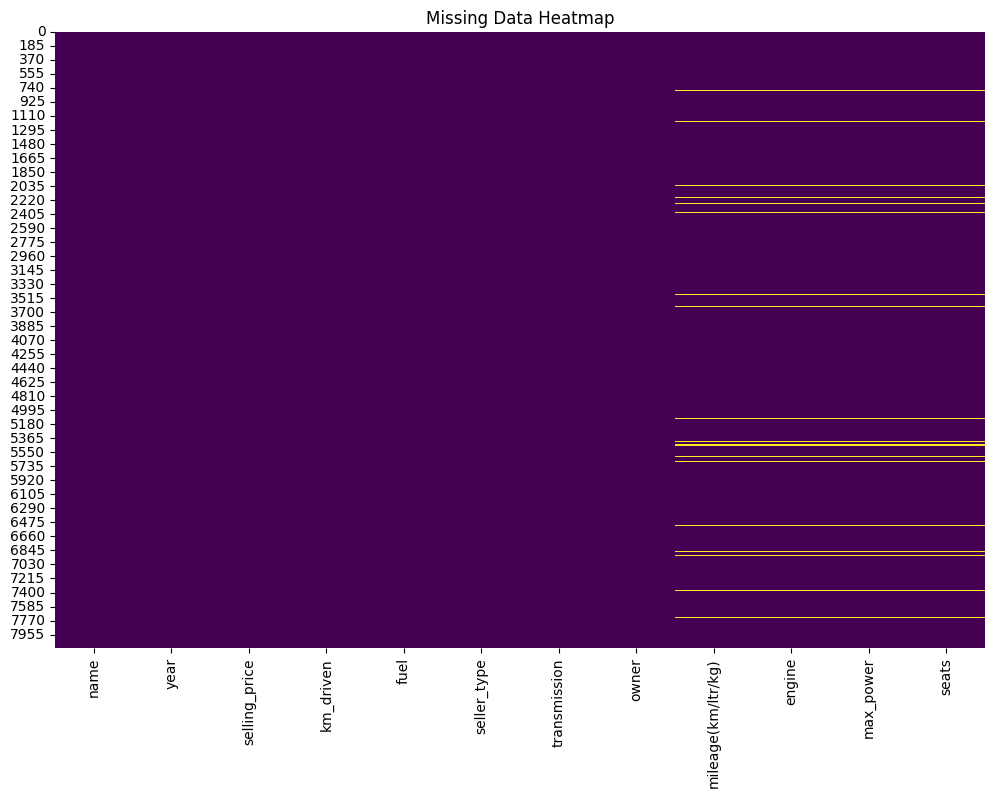

In [6]:
# Visualize missing data
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [7]:
# Handle missing values
data = data.dropna()  # For simplicity, drop rows with missing values

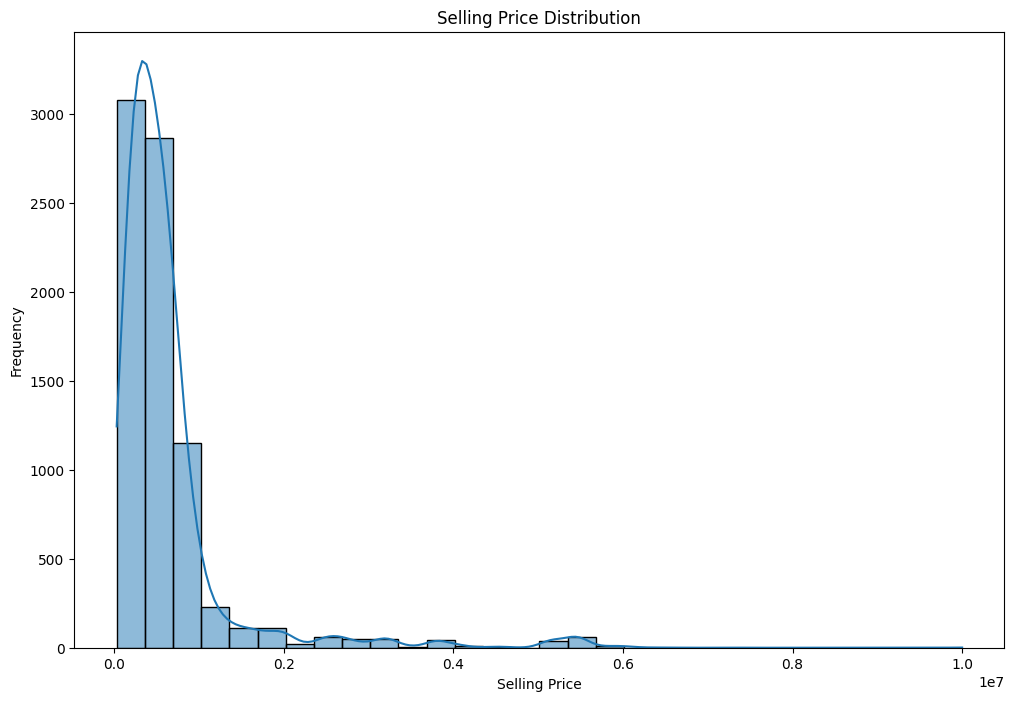

In [8]:
# Visualize the distribution of the target variable (selling_price)
plt.figure(figsize=(12, 8))
sns.histplot(data['selling_price'], kde=True, bins=30)
plt.title('Selling Price Distribution')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Visualize the distribution of numeric features
numeric_features = ['mileage(km/ltr/kg)', 'engine', 'max_power', 'seats']

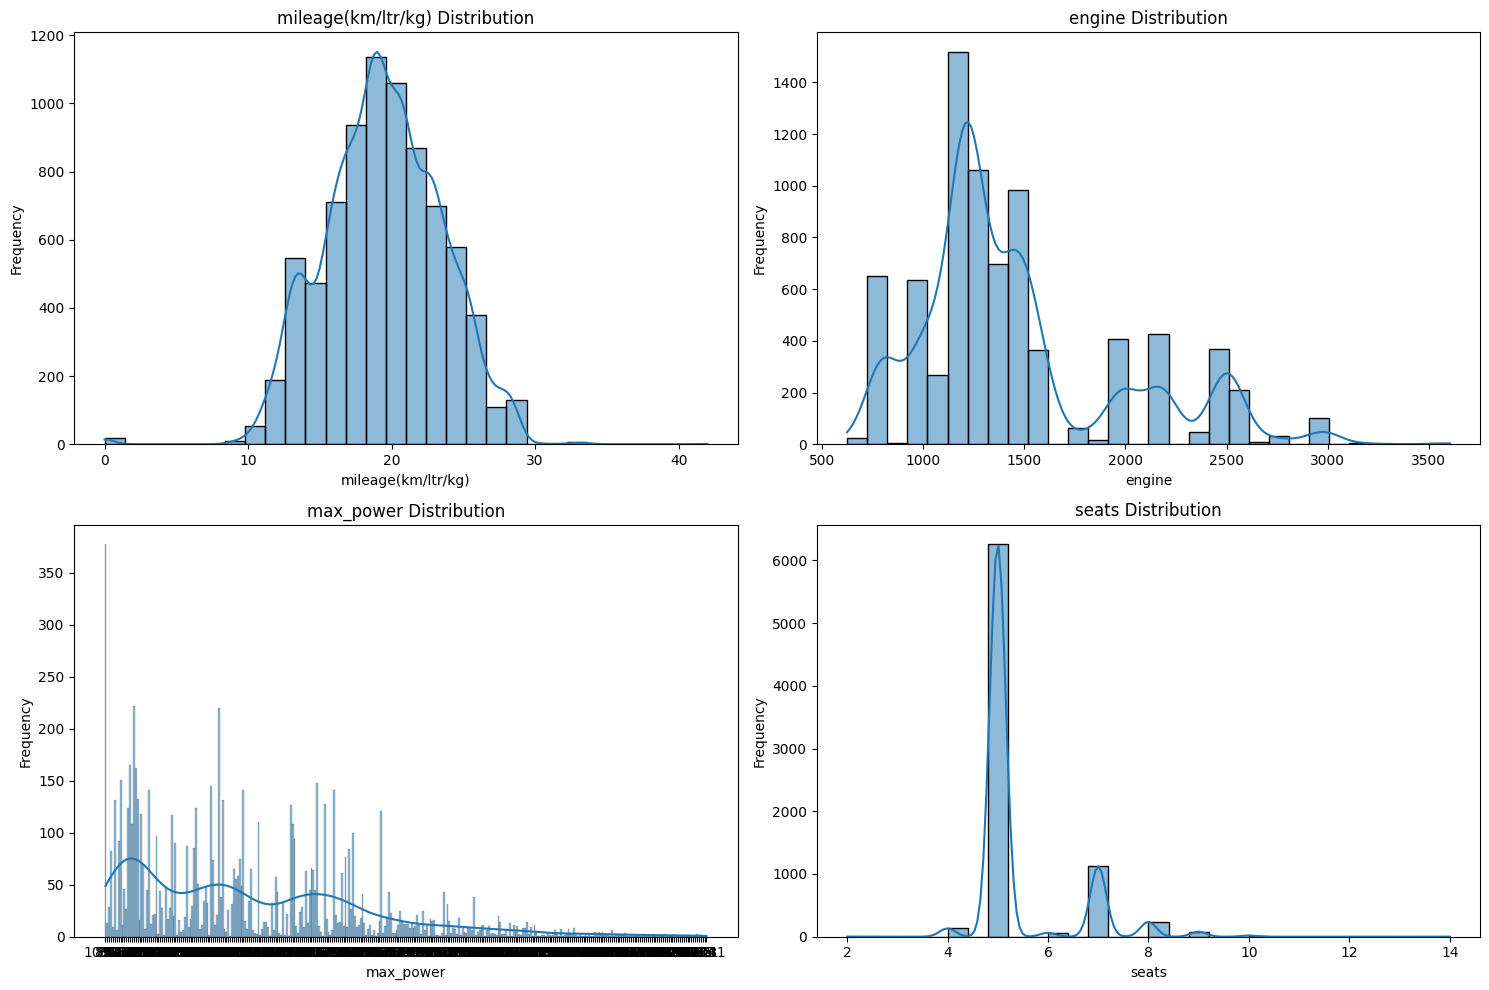

In [10]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [12]:
# Correlation matrix for numeric data
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

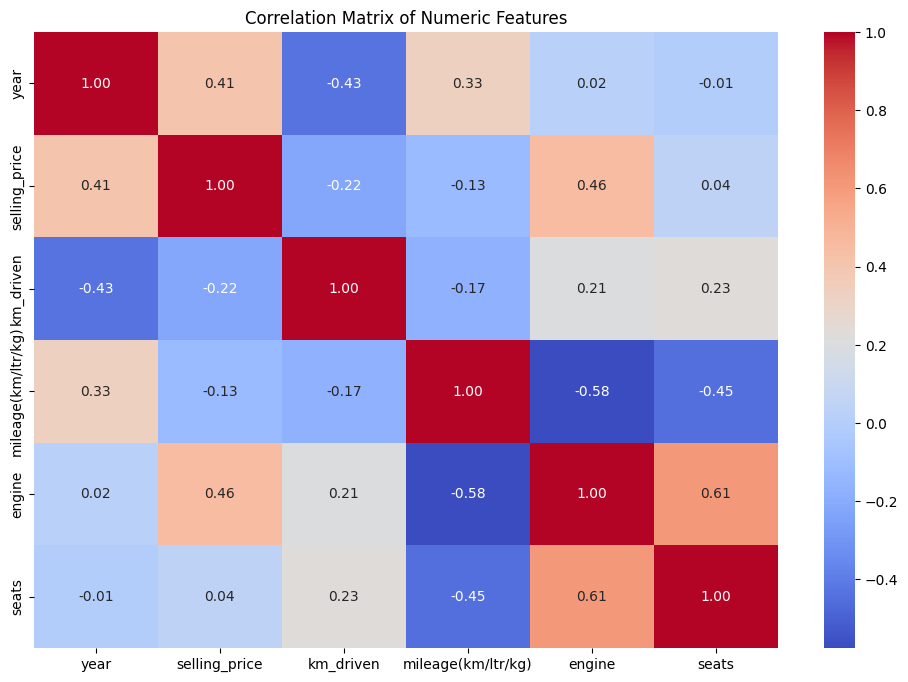

In [13]:
# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

<Figure size 1200x800 with 0 Axes>

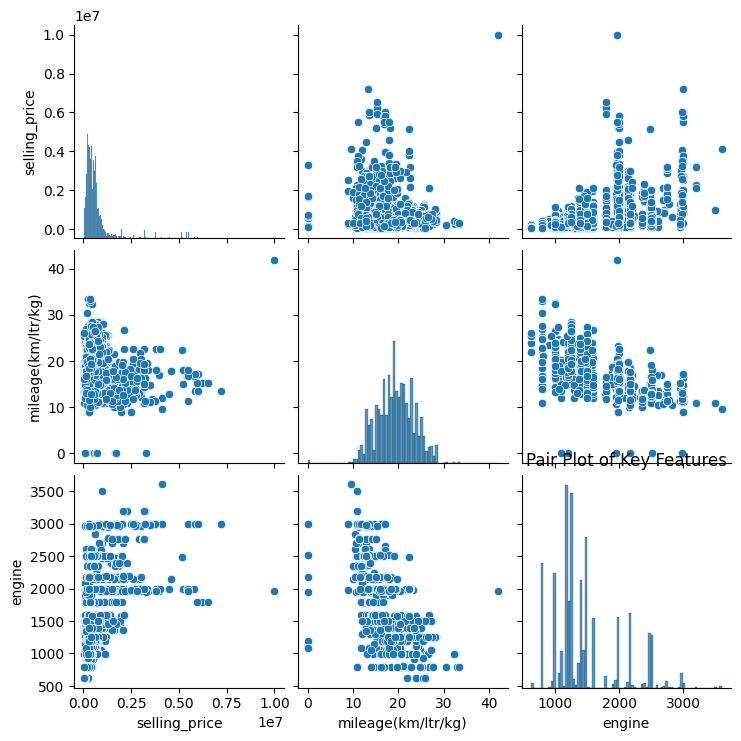

In [14]:
# Pair Plots for selected features
plt.figure(figsize=(12, 8))
sns.pairplot(data[['selling_price', 'mileage(km/ltr/kg)', 'engine', 'max_power']])
plt.title('Pair Plot of Key Features')
plt.show()

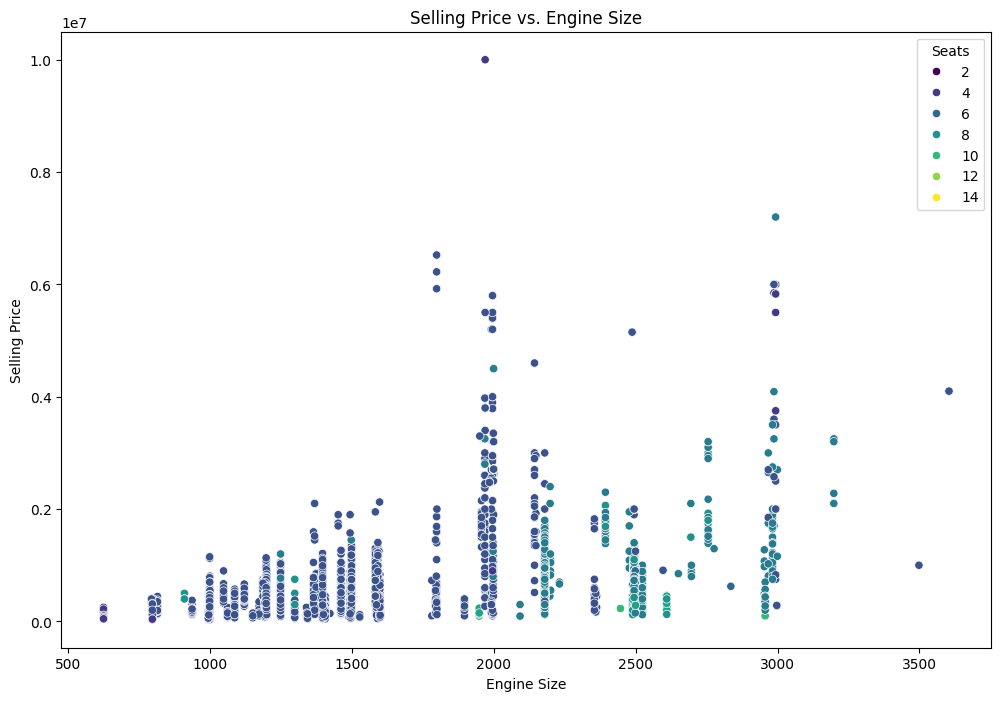

In [15]:
# Additional EDA: Visualizing Relationships
plt.figure(figsize=(12, 8))
sns.scatterplot(x=data['engine'], y=data['selling_price'], hue=data['seats'], palette='viridis')
plt.title('Selling Price vs. Engine Size')
plt.xlabel('Engine Size')
plt.ylabel('Selling Price')
plt.legend(title='Seats')
plt.show()

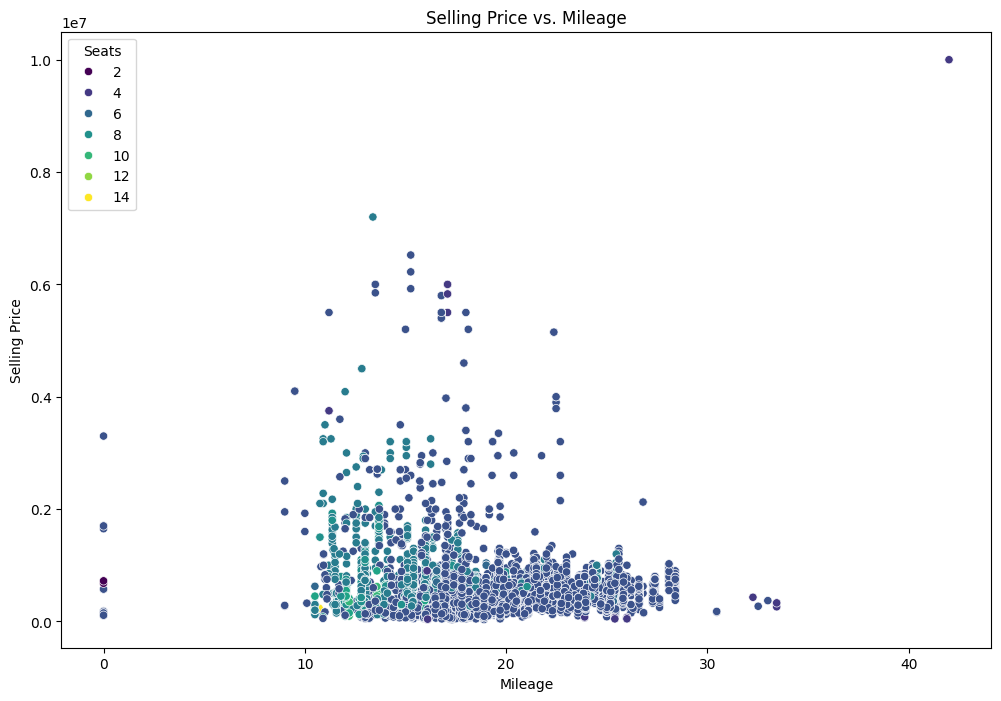

In [16]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=data['mileage(km/ltr/kg)'], y=data['selling_price'], hue=data['seats'], palette='viridis')
plt.title('Selling Price vs. Mileage')
plt.xlabel('Mileage')
plt.ylabel('Selling Price')
plt.legend(title='Seats')
plt.show()

In [19]:
# Ensure columns are of type string
data['mileage(km/ltr/kg)'] = data['mileage(km/ltr/kg)'].astype(str)
data['engine'] = data['engine'].astype(str)
data['max_power'] = data['max_power'].astype(str)

# Feature Engineering: Converting and Scaling
# Extract numeric values from string and convert to numeric
data['mileage(km/ltr/kg)'] = pd.to_numeric(data['mileage(km/ltr/kg)'].str.extract(r'(\d+\.?\d*)')[0], errors='coerce')
data['engine'] = pd.to_numeric(data['engine'].str.extract(r'(\d+\.?\d*)')[0], errors='coerce')
data['max_power'] = pd.to_numeric(data['max_power'].str.extract(r'(\d+\.?\d*)')[0], errors='coerce')

# Fill missing values with median
data['mileage(km/ltr/kg)'].fillna(data['mileage(km/ltr/kg)'].median(), inplace=True)
data['engine'].fillna(data['engine'].median(), inplace=True)
data['max_power'].fillna(data['max_power'].median(), inplace=True)
data['seats'].fillna(data['seats'].median(), inplace=True)

# Encoding categorical variables (if any)
data = pd.get_dummies(data, drop_first=True)


In [20]:
print(data.dtypes)


year                            int64
selling_price                   int64
km_driven                       int64
mileage(km/ltr/kg)            float64
engine                        float64
                               ...   
transmission_Manual              bool
owner_Fourth & Above Owner       bool
owner_Second Owner               bool
owner_Test Drive Car             bool
owner_Third Owner                bool
Length: 1999, dtype: object


In [21]:
print(data[['mileage(km/ltr/kg)', 'engine', 'max_power']].head())


   mileage(km/ltr/kg)  engine  max_power
0               23.40  1248.0      74.00
1               21.14  1498.0     103.52
2               17.70  1497.0      78.00
3               23.00  1396.0      90.00
4               16.10  1298.0      88.20


In [22]:
# Feature Engineering: Adding more features
data['age'] = 2024 - data['year']  # Assuming the dataset is from the year 2024

# Price per Mileage: Selling price divided by mileage
data['price_per_mileage'] = data['selling_price'] / data['mileage(km/ltr/kg)']

print(data[['age', 'price_per_mileage']].head())


   age  price_per_mileage
0   10       19230.769231
1   10       17502.365184
2   18        8926.553672
3   14        9782.608696
4   17        8074.534161


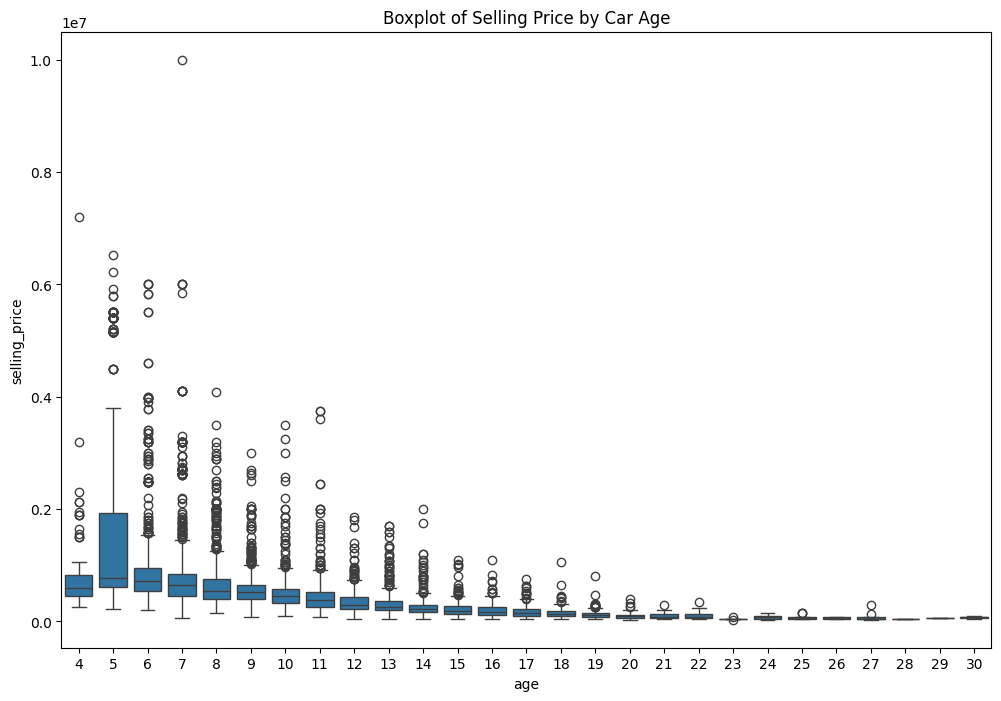

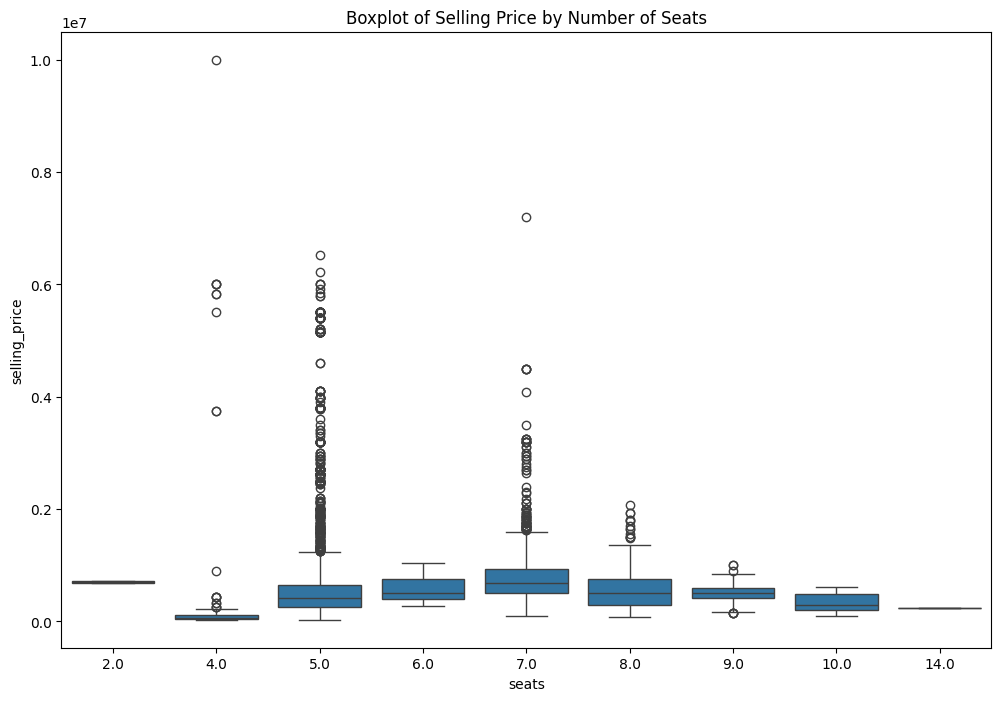

In [23]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='age', y='selling_price', data=data)
plt.title('Boxplot of Selling Price by Car Age')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='seats', y='selling_price', data=data)
plt.title('Boxplot of Selling Price by Number of Seats')
plt.show()


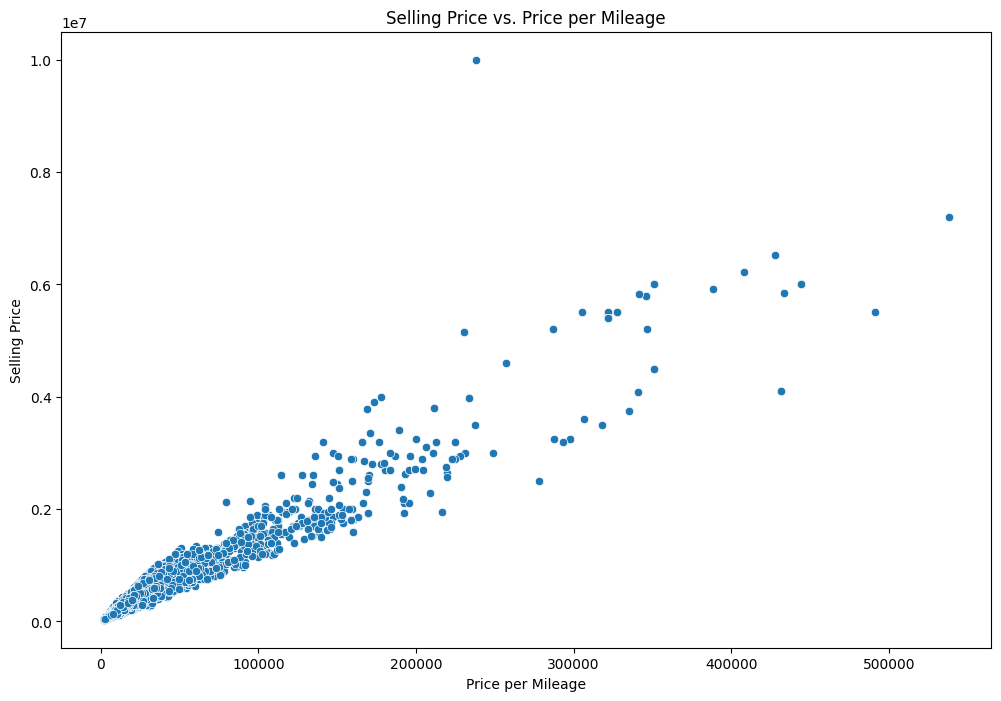

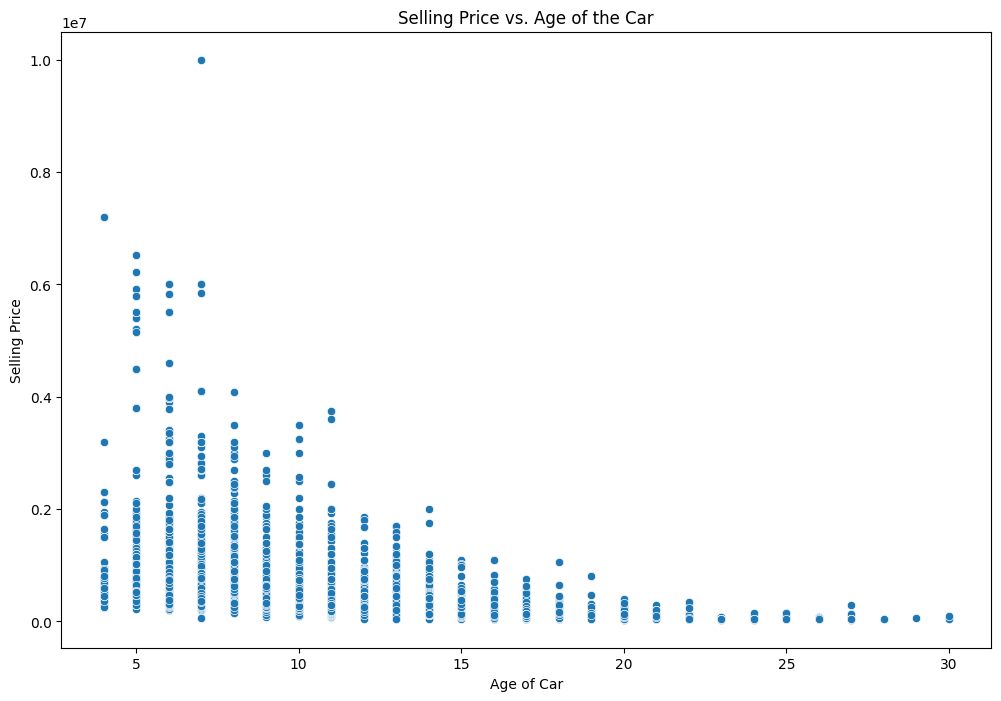

In [24]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=data['price_per_mileage'], y=data['selling_price'])
plt.title('Selling Price vs. Price per Mileage')
plt.xlabel('Price per Mileage')
plt.ylabel('Selling Price')
plt.show()

# Scatter plot for car age
plt.figure(figsize=(12, 8))
sns.scatterplot(x='age', y='selling_price', data=data)
plt.title('Selling Price vs. Age of the Car')
plt.xlabel('Age of Car')
plt.ylabel('Selling Price')
plt.show()


In [28]:
# Check for NaN values
print("NaN values in dataset:")
print(X_train.isnull().sum())

# Check for Infinity or extremely large values
print("Infinite or extremely large values in dataset:")
print(np.isinf(X_train).sum())  # This will show if there are infinite values in each column
print("Max values in dataset:")
print(X_train.max())  # Check if there are any unusually large values


NaN values in dataset:
year                    0
km_driven               0
mileage(km/ltr/kg)      0
engine                  0
max_power               0
                       ..
owner_Second Owner      0
owner_Test Drive Car    0
owner_Third Owner       0
age                     0
price_per_mileage       0
Length: 2000, dtype: int64
Infinite or extremely large values in dataset:
year                     0
km_driven                0
mileage(km/ltr/kg)       0
engine                   0
max_power                0
                        ..
owner_Second Owner       0
owner_Test Drive Car     0
owner_Third Owner        0
age                      0
price_per_mileage       13
Length: 2000, dtype: int64
Max values in dataset:
year                       2020
km_driven               1500000
mileage(km/ltr/kg)         42.0
engine                   3604.0
max_power                 400.0
                         ...   
owner_Second Owner         True
owner_Test Drive Car       True
owner_Third Ow

In [29]:
# Fill NaN values with the median of the respective column
X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)

# Replace infinity values with NaN and then fill those with the median
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill again after replacing infinities
X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)


In [30]:
# Re-run the model after cleaning the data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate performance
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")


MAE: 6853.294469026548
RMSE: 34066.09165467821
R2 Score: 0.9984476163228083


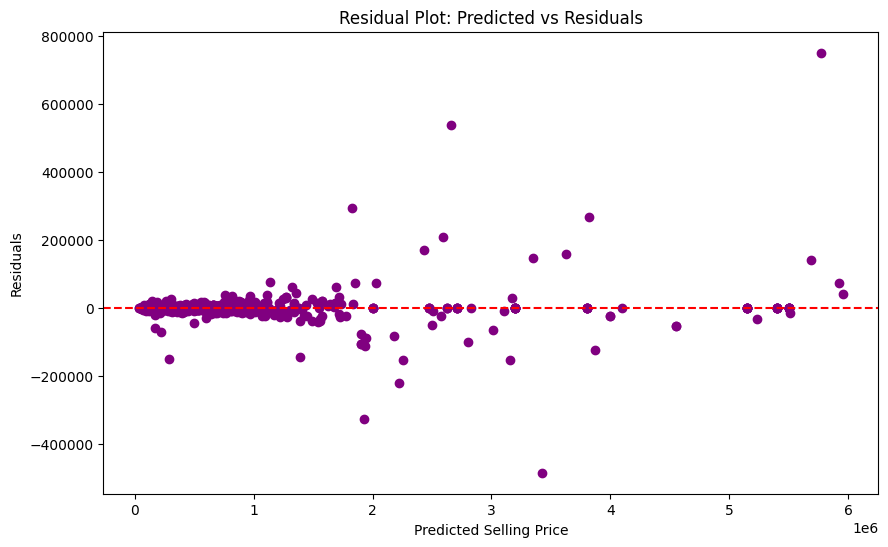

In [32]:
# Residuals: Actual - Predicted
residuals = y_test - y_pred

# Plot Residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot: Predicted vs Residuals')
plt.xlabel('Predicted Selling Price')
plt.ylabel('Residuals')
plt.show()


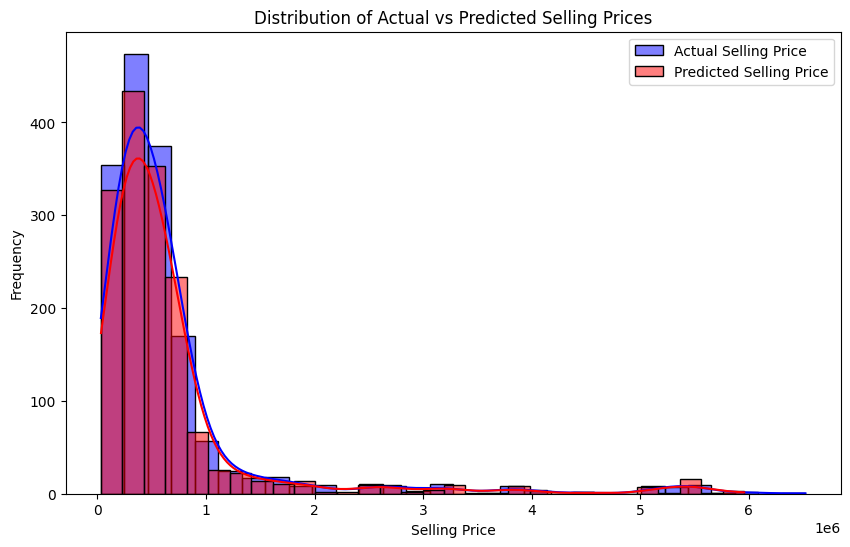

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color='blue', label='Actual Selling Price', kde=True, bins=30)
sns.histplot(y_pred, color='red', label='Predicted Selling Price', kde=True, bins=30)
plt.title('Distribution of Actual vs Predicted Selling Prices')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


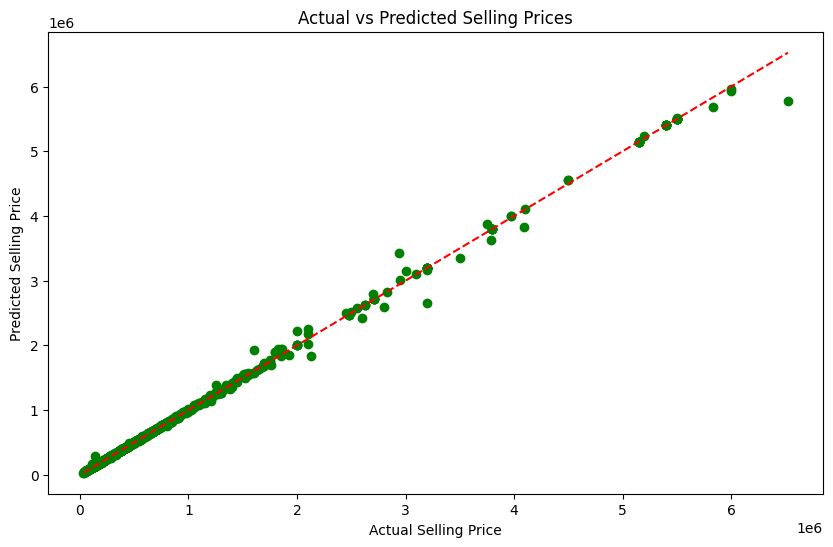

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Perfect prediction line
plt.title('Actual vs Predicted Selling Prices')
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.show()


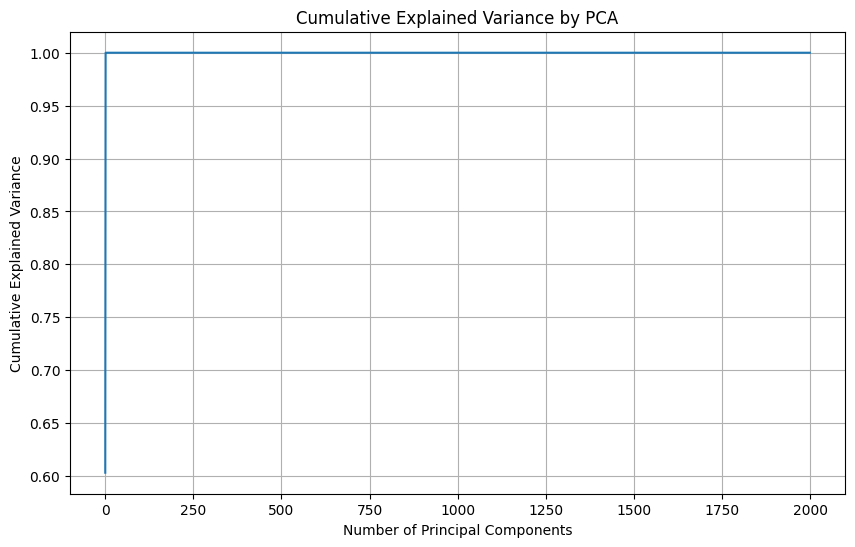

In [40]:
from sklearn.decomposition import PCA

# Performing PCA
pca = PCA()
pca.fit(X_train)

# Plotting cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance by PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


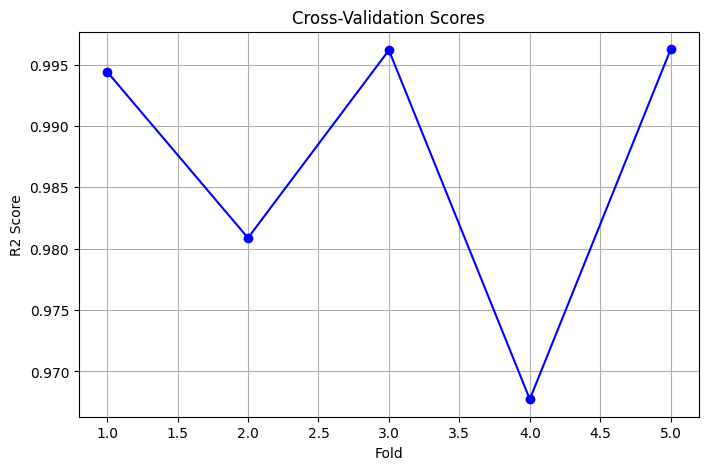

Cross-validation scores: [0.99442008 0.98087905 0.99617351 0.9677401  0.99625122]
Average cross-validation score: 0.9871


In [41]:
# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

# Plot cross-validation scores
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), cv_scores, marker='o', color='blue')
plt.title('Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.grid(True)  # Adding grid for clarity
plt.show()

# Print the cross-validation scores and the average score
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {np.mean(cv_scores):.4f}')


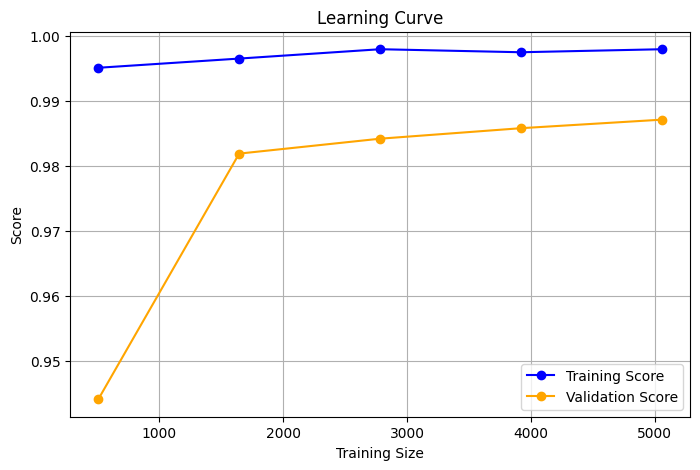

In [42]:
from sklearn.model_selection import learning_curve

# Get the learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

# Calculate the mean of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Validation Score')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.grid(True)  # Adding grid for clarity
plt.legend()
plt.show()


In [45]:
print(data.columns)


Index(['year', 'selling_price', 'km_driven', 'mileage(km/ltr/kg)', 'engine',
       'max_power', 'seats', 'name_Ambassador Classic 2000 DSZ AC PS',
       'name_Ambassador Grand 1500 DSZ BSIII',
       'name_Ambassador Grand 2000 DSZ PW CL',
       ...
       'fuel_Petrol', 'seller_type_Individual', 'seller_type_Trustmark Dealer',
       'transmission_Manual', 'owner_Fourth & Above Owner',
       'owner_Second Owner', 'owner_Test Drive Car', 'owner_Third Owner',
       'age', 'price_per_mileage'],
      dtype='object', length=2001)


In [46]:
data.columns = data.columns.str.strip()  # Remove leading/trailing spaces


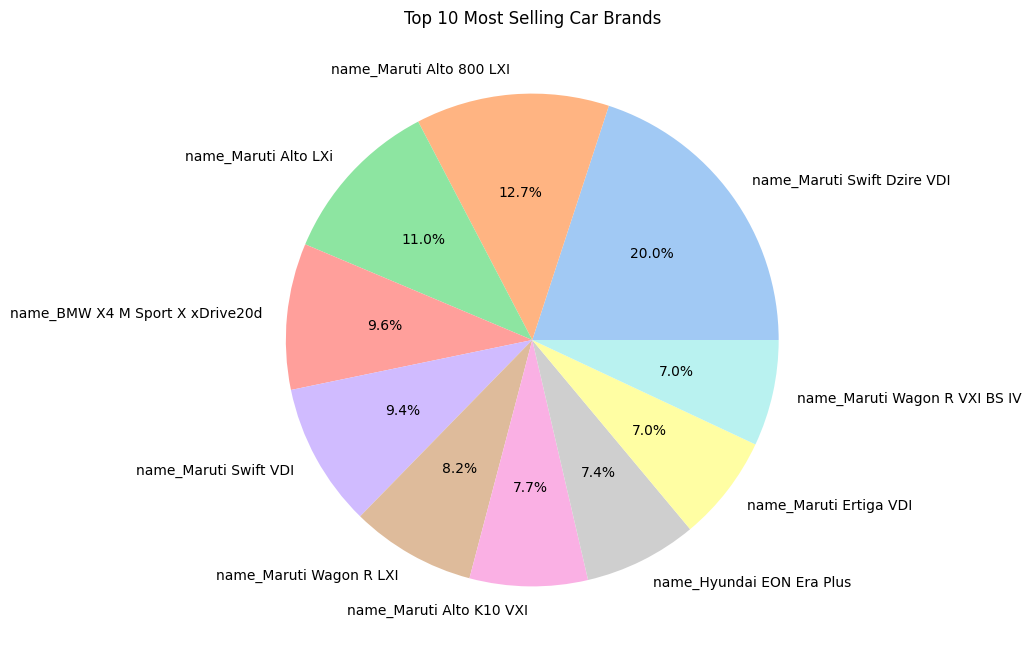

In [49]:
# Identify car name columns
car_name_columns = [col for col in data.columns if col.startswith('name_')]

# Aggregate car brand counts
car_name_counts = data[car_name_columns].sum()

# Get the top 10 most selling car brands
top_10_car_names = car_name_counts.nlargest(10)

# Plot pie chart for the top 10 car brands
plt.figure(figsize=(12, 8))
plt.pie(top_10_car_names, labels=top_10_car_names.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Top 10 Most Selling Car Brands')
plt.show()


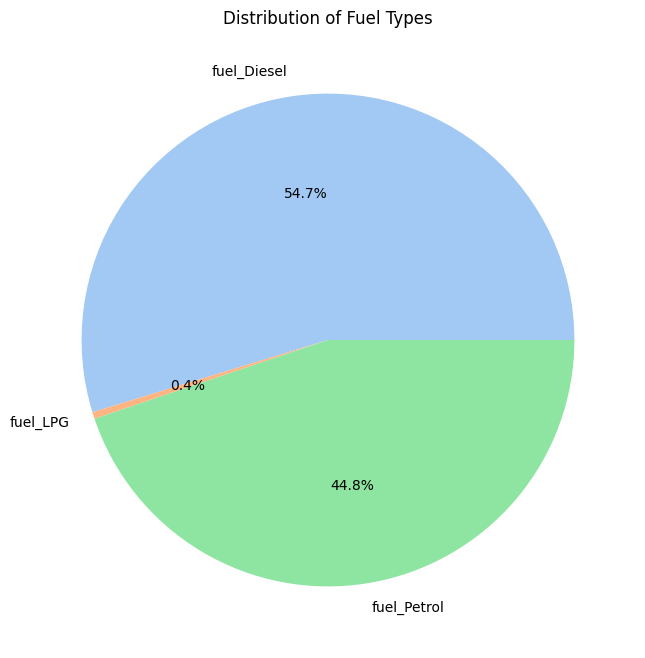

In [51]:
# Plot pie chart for fuel types
fuel_types = data.filter(like='fuel_').sum()
plt.figure(figsize=(12, 8))
plt.pie(fuel_types, labels=fuel_types.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Distribution of Fuel Types')
plt.show()


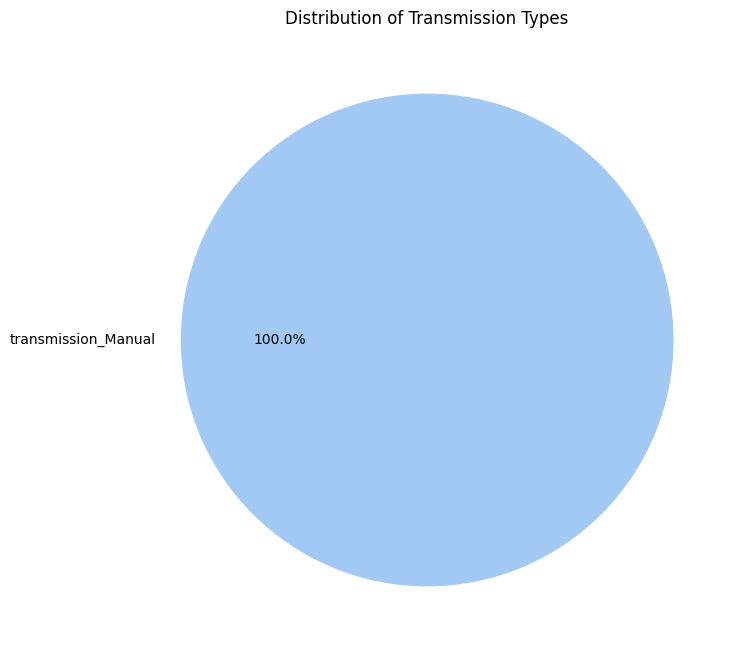

In [52]:
# Plot pie chart for transmission types
transmissions = data.filter(like='transmission_').sum()
plt.figure(figsize=(12, 8))
plt.pie(transmissions, labels=transmissions.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Distribution of Transmission Types')
plt.show()

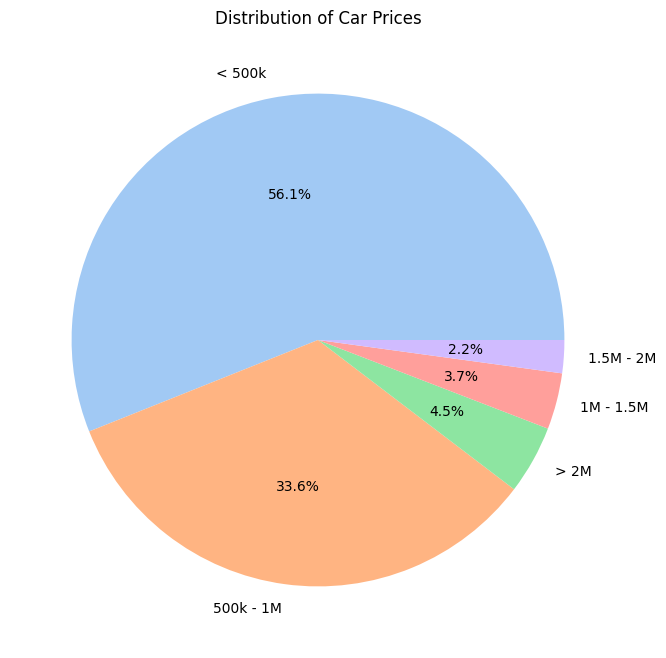

In [53]:
# Define price ranges
bins = [0, 500000, 1000000, 1500000, 2000000, np.inf]
labels = ['< 500k', '500k - 1M', '1M - 1.5M', '1.5M - 2M', '> 2M']

# Create a new column for price ranges
data['price_range'] = pd.cut(data['selling_price'], bins=bins, labels=labels)

# Count the number of cars in each price range
price_range_counts = data['price_range'].value_counts()

# Plot pie chart for price ranges
plt.figure(figsize=(12, 8))
plt.pie(price_range_counts, labels=price_range_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Distribution of Car Prices')
plt.show()
